In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import os.path
import pickle
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics         import roc_curve

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5


# Useful functions
from utils import *

In [2]:
# Load tttt data
data = pd.read_csv('../data/4topSM.csv')
df = pd.DataFrame(data)
df = remove_bjets_info(df)
df = df.drop(['m4top'],axis=1)
df['isSig'] = 1

# Load ttV data
data_ttV = pd.read_csv('../data/ttV.csv')
df_ttV = pd.DataFrame(data_ttV)
df_ttV = remove_bjets_info(df_ttV)
df_ttV = df_ttV.drop(['m4top'],axis=1)
df_ttV['isSig'] = 0

# Combined dataset & prepare features/target (here isSig)
data  = pd.concat( [df,df_ttV] )
dataX = data.drop('isSig',axis=1)
dataY = data['isSig']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [5]:
# Train various algorithms

# 1. Random forest
if (os.path.exists('../data/random_forest_classification.dat')):
    rf_clf = open_model_from_file('../data/random_forest_classification.dat')
else:
    rf_clf = RandomForestRegressor(n_estimators=500,n_jobs=-1,max_depth=10).fit(trainX, trainY)
    save_model_in_file(rf_clf,'../data/random_forest_classification.dat')

In [7]:
# 2. Adaptative boosting
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
if (os.path.exists('../data/adaboost_classification.dat')):
    ab_clf = open_model_from_file('../data/adaboost_classification.dat')
else:
    ab_clf = AdaBoostRegressor(n_estimators=500, base_estimator=DecisionTreeRegressor(max_depth=10)).fit(trainX, trainY)
    save_model_in_file(ab_clf,'../data/adaboost_classification.dat')

In [8]:
# 3. Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
if (os.path.exists('../data/gradboost_classification.dat')):
    gb_clf = open_model_from_file('../data/gradboost_classification.dat')
else:
    gb_clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10).fit(trainX,trainY)
    save_model_in_file(gb_clf,'../data/gradboost_classification.dat')

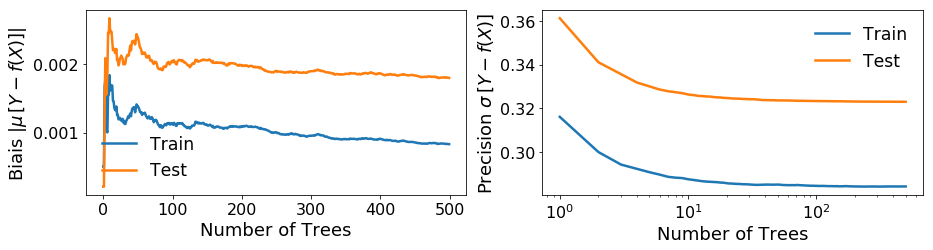

In [9]:
plot_perf_randomforest_vs_ntree(rf_clf,trainX,trainY,testX,testY)

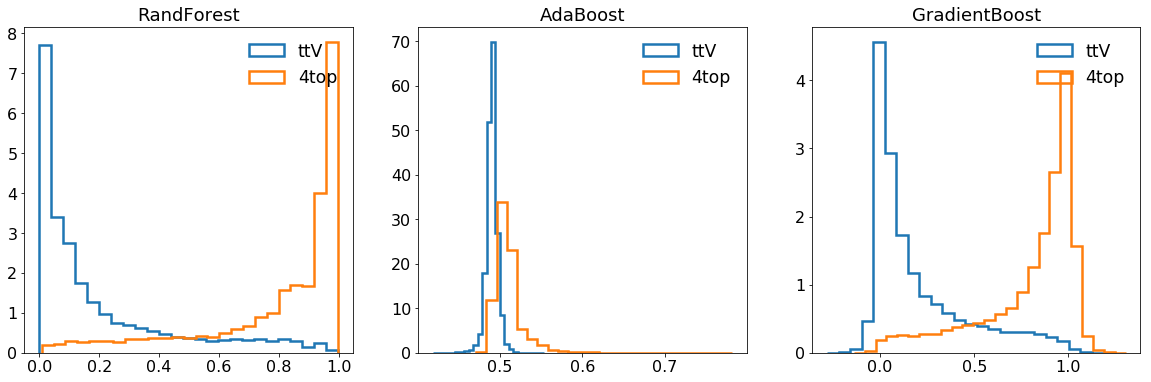

In [17]:
testXsig = testX[testY==1]
testXbkg = testX[testY==0]

i=0
classifiers=[[rf_clf,'RandForest'],[ab_clf,'AdaBoost'],[gb_clf,'GradientBoost']]
plt.figure(figsize=(20,6))
for regre,name in classifiers:

    i=i+1
    plt.subplot(1,3,i)
    plt.hist(regre.predict(testXbkg), density=True, bins=25, histtype='step', linewidth=2.5, label='ttV')
    plt.hist(regre.predict(testXsig), density=True, bins=25, histtype='step', linewidth=2.5, label='4top')
    plt.title(name)
    plt.legend()

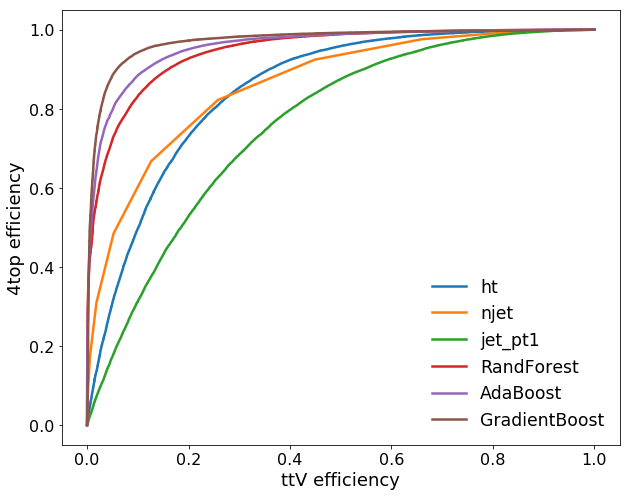

In [19]:
selection        = 'njet>0'
VariableToTest   = ['ht','njet','jet_pt1']
RegressorsToTest = [[rf_clf,'RandForest'],[ab_clf,'AdaBoost'],[gb_clf,'GradientBoost']]
plot_roc_curves(df, df_ttV, VariableToTest, RegressorsToTest,selection)